# Markov Chain Monte Carlo

Author: Fred J. Hickernell + ChatGPT

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vz}{\boldsymbol{z}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/GeneratingRandomVectors.ipynb?flush_cache=true)

In [1]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

### Import needed packages and initialize some parameters

In [12]:
import sys, time
import numpy as np, scipy as sp, matplotlib.pyplot as plt
import qmcpy as qp
from pathlib import Path
from IPython.display import display, Markdown
REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))
from classlib.sampling import metropolis, parallel_tempering, accept_reject
from classlib.discrepancy import (mmd, make_kernel, make_cd_kernel,
    AnalyticalMeasure, cd_uniform_k_mean, cd_uniform_k_self, show_mmd_usage)
import nbviz as nb
nb.init(use_tex=True)     # styling, Tol cycle, CSS
colors, TINY = nb.TOL_BRIGHT, nb.TINY

## Recalling Acceptance Rejection Sampling
To sample from complicated target (unnormalized) probability densities, one can sample from a suitable proposal density and then either accept or reject the samples.

At a high level, there is a
- a target (unnormalized) PDF, $\varrho$
- a proposal PDF, $\varrho_Z$
- a constant $M$ such that $\varrho(z) \le M \varrho_Z(z)$
A sample, $Z\sim \varrho_Z$ and $U \sim \mathcal{U}[0,1]$, yields a new sample from the target distribution if
$$
U \le \varrho(Z)/[M\varrho_Z(Z)] \qquad \textsf{or equivalently} \qquad \log(U) + \log(M) + \log(\varrho_Z(Z)) - \log(\varrho(Z)) \le 0
$$

The code for a general acceptance-rejection sampler is in `classlib/sampling/accept_reject.py`. We need to supply logarithms of the target and proposal densities because logarithms are more numerically stable.

### A banana shaped unnormalized density
The following is an example of a nontrivial densit for which it would be difficult to use a quantile function to generate random samples

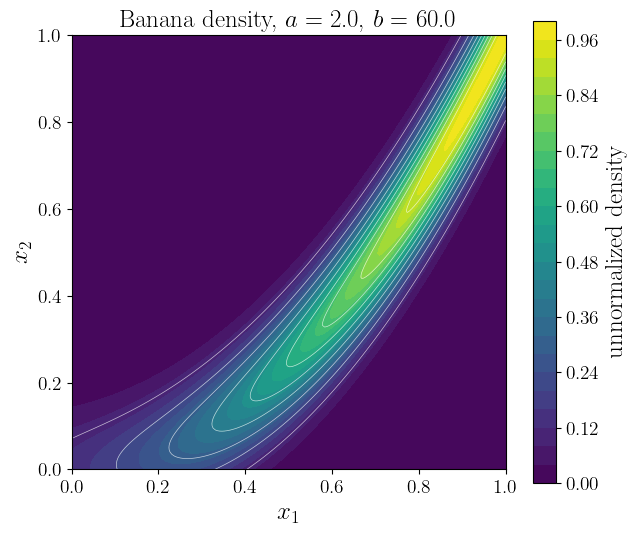

In [3]:
def log_banana(points, a=2.0, b=60.0):
    """
    Banana-shaped log-density on [0,1]^2.

    Parameters
    ----------
    points : array_like
        - shape (d,) with d=2 → returns float
        - shape (n,2) → returns array (n,)

    Returns
    -------
    float or ndarray
        log-density values (−inf outside the unit square).
    """
    pts = np.asarray(points, float)
    single = (pts.ndim == 1)
    pts = np.atleast_2d(pts)   # ensure shape (n,2)

    x, y = pts[:, 0], pts[:, 1]
    inside = (0 <= x) & (x <= 1) & (0 <= y) & (y <= 1)

    out = np.full(pts.shape[0], -np.inf, dtype=float)
    out[inside] = -a * (1 - x[inside])**2 - b * (y[inside] - x[inside]**2)**2

    return float(out[0]) if single else out

#Plot the banana
a = 2.
b = 60.
def plot_banana(a=a, b=b, n_grid=200):
    xs = np.linspace(0, 1, n_grid)
    ys = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(xs, xs)
    pts = np.column_stack([X.ravel(), Y.ravel()])
    Z = np.exp(log_banana(pts, a=a, b=b)).reshape(X.shape)  #take the exponential of the log banana
    fig, ax = plt.subplots(figsize=(7,6))
    cf = ax.contourf(X, Y, Z, levels=30, cmap="viridis")
    cs = ax.contour(X, Y, Z, levels=10, colors="white", linewidths=0.5, alpha=0.7)
    ax.set_aspect('equal')
    fig.colorbar(cf, ax=ax, label="unnormalized density")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"Banana density, $a=$ {a}, $b=$ {b}")
    return ax

plot_banana(a=a, b=b);

{'proposed': 100100, 'accepted': 10000, 'pilot_accept_rate': 0.08, 'final_accept_rate': 0.0999000999000999, 'batches': 3, 'mode': 'unit-peak', 'M': None, 'elapsed_time': 0.002367500012042001}


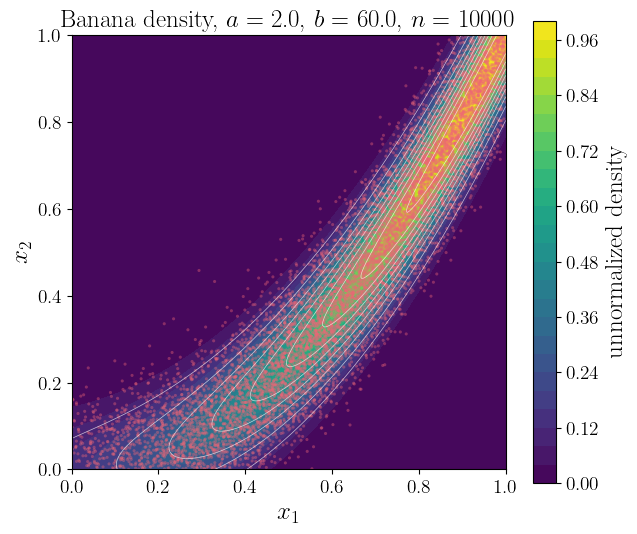

In [4]:
def sampler_uniform_01(d, n, rng=None):  #the uniform sampler to 
    rng = np.random.default_rng(rng)
    return rng.random((n,d))   # uniform on [0,1]^2

#Run the acceptance-rejection sampler
#Note that the uniform density proposal always lies above the target
n = 10_000
AR_samples, AR_info = accept_reject(
    log_target_density = lambda z: log_banana(z, a=a, b=b),
    proposal_sampler = lambda n, rng: sampler_uniform_01(2,n),
    n_samples = n
)
print(AR_info)
marker_size = 5
ax = plot_banana(a=a, b=b)
ax.scatter(AR_samples[:,0], AR_samples[:,1], s=marker_size, c=colors["red"], alpha=0.4, edgecolor="none")
ax.set_title(f"Banana density, $a=$ {a}, $b=$ {b}, $n=$ {n}");


## Markov Chain Monte Carlo (MCMC)

The weakness in acceptance-rejection sampling is that it samples from just one one proposal distribution.  Markov chain Monte Carlo overcomes this weakness by moving from positions of low density to those of higher densitiy.  Next we introduce the Metropolis-Hastings version of MCMC and contrast it with acceptance-rejection sampling.

Suppose that
* You really want to sample $\boldsymbol{X}$ with known (unnormalized) target density $\varrho$
* You have a proposal density $\varrho_{\text{new} | \text{old}}$ to select the next point starting from where you are
  
Metropolis-Hastings sampling proceeds as follows
$$
\begin{array}{l}
\text{Given } x_0 \\
\text{For } i = 0 \text{ to } n-1 \\
\begin{array}{lrl}
& \text{Generate } & z \sim \varrho_{\text{new} | \text{old}}(\cdot | x_i) \\
&& U \sim \mathcal{U}[0,1] \\
& \text{If } &U \le \min \left(1, \frac{\varrho(z) \varrho_{\text{new} | \text{old}}( x_i | z)}{\varrho(x_i) \varrho_{\text{new} | \text{old}}(z | x_i)}  \right) \\
&& x_{i+1} = z \\
& \text{Else} \\
&& x_{i+1} = x_i
\end{array}
\end{array}
$$

If $\varrho_{\text{new} | \text{old}}( x | z)= \varrho_{\text{new} | \text{old}}(z | x)$. then the decision criterion simplifies and this is called the Metropolis algorithm.

We have this algorithm in `classlib/sampling/metropolis.py`.

0.4841


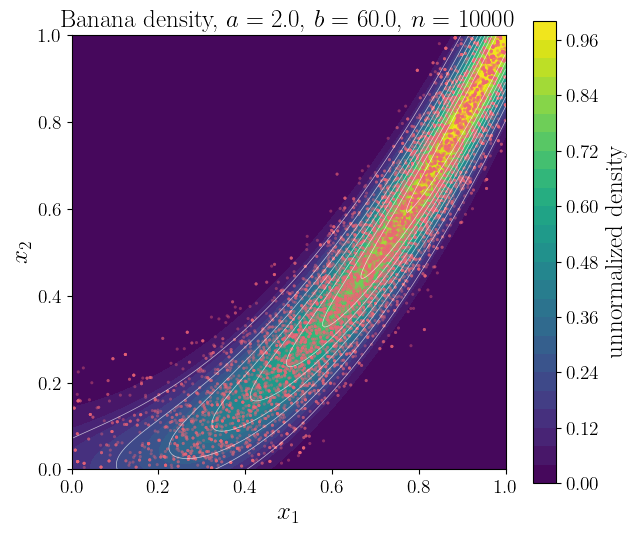

In [5]:
n = 10_000
x0 = np.array([[0.5,0.5]])
std_dev = 0.1
met_samples, acc = metropolis(log_target_density = lambda z: log_banana(z, a=a, b=b),
                     x0=x0, n_samples=n, proposal_sd=std_dev)
print(acc)
marker_size = 5
ax = plot_banana(a=a, b=b)
ax.scatter(met_samples[:,0], met_samples[:,1], s=marker_size, c=colors["red"], alpha=0.4, edgecolor="none")
ax.set_title(f"Banana density, $a=$ {a}, $b=$ {b}, $n=$ {n}");

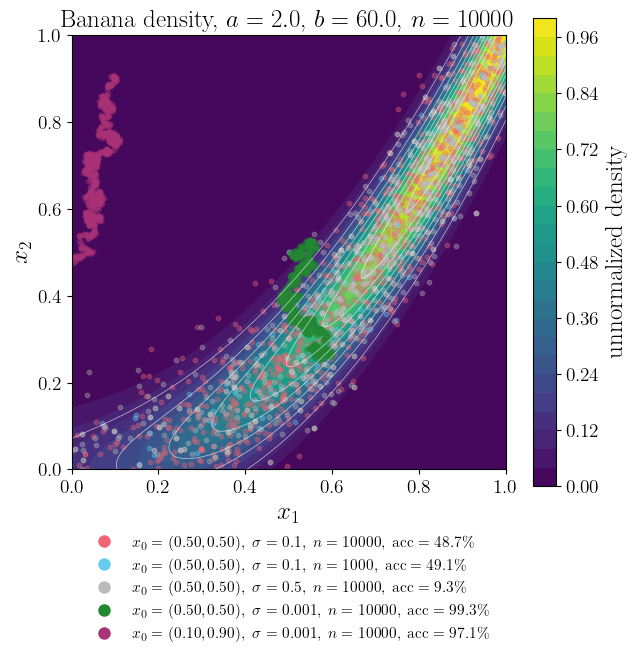

In [6]:
tol_contrast = ["red", "cyan", "gray", "green", "purple"]  # --- use Paul Tol's Bright palette (contrasting with viridis) ---
met_param = [  #different starting points and standard deviations for the proposal density
    {"n" : 10_000, "x0": (0.5, 0.5), "sd": 1e-1},
    {"n" : 1_000, "x0": (0.5, 0.5), "sd": 1e-1},
    {"n" : 10_000, "x0": (0.5, 0.5), "sd": 5e-1},
    {"n" : 10_000, "x0": (0.5, 0.5), "sd": 1e-3},
    {"n" : 10_000, "x0": (0.1, 0.9), "sd": 1e-3},
]
marker_size = 10
plot_every = 10  #plot some of the points
alph = 0.35
ax = plot_banana(a=a, b=b)
legend_labels, legend_colors = [], []
for i, cfg in enumerate(met_param):
    x0 = np.asarray(cfg["x0"], float).reshape(1, 2)
    sd = float(cfg["sd"])
    n = cfg["n"]

    t0 = time.perf_counter()
    samples, acc = metropolis(
        log_target_density=lambda z: log_banana(z, a=a, b=b),
        x0=x0, n_samples=n, proposal_sd=sd
    )
    cfg["samples"] = samples
    cfg["time"] = time.perf_counter() - t0   # elapsed seconds

    col = colors[tol_contrast[i % len(tol_contrast)]]
    label = rf"$x_0=({x0[0,0]:.2f},{x0[0,1]:.2f}),\ \sigma={sd:g},\ n={n:.0f},\ \mathrm{{acc}}={100*acc:.1f}\%$"

    ax.scatter(
        samples[::plot_every, 0],
        samples[::plot_every, 1],
        s=marker_size, c=col, alpha=alph,
        edgecolor=None
    )

    legend_labels.append(label)
    legend_colors.append(col)

ax.set_title(rf"Banana density, $a={a}$, $b={b}$, $n={n}$")
from matplotlib.lines import Line2D  # Build legend handles with labels
handles = [
    Line2D([0], [0],
           marker="o", linestyle="",
           markersize=9,
           markerfacecolor=c,
           markeredgecolor="none",   # <- no border
           markeredgewidth=0,        # <- make sure
           alpha=1.0,
           label=lab)
    for c, lab in zip(legend_colors, legend_labels)
]
leg = ax.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    frameon=False,
    ncol=1,
    fontsize=11
)
ax.figure.subplots_adjust(bottom=0.1) # Give the legend some room below the axes

## Maximum Mean Discrepancy
How do we evaluate the quality of our sample.  It is not easy.  However, we can compute the difference between two samples.

Given a symmetric, positive definite kernel, $K: \mathcal{X} \times \mathcal{X} \to \reals$, the ***discrepancy*** between two empirical distributions is defined by  

$$
D^2\bigl(\{\vx_i\}_{i=0}^{m-1},\{\vz_i\}_{i=0}^{n-1}\bigr)
= \frac{1}{m^2} \sum_{i,j=0}^{n-1} K(\vx_i,\vx_i) - \frac 2{mn} \sum_{i,j=0}^{n-1,m-1} K(\vx_i,\vz_j) + \frac{1}{n^2} \sum_{i,j=0}^{n-1} K(\vz_i,\vz_j)
$$

<div style="background-color:#e6f7ff; border-left:5px solid #66CCEE; padding:0.5em;">
With the help of ChatGPT, we have created an MMD function
</div>

In [7]:
show_mmd_usage()


### MMD / Discrepancy Quick Guide

- **Kernels**:
  - `"se"` / `"sqexp"`: Squared Exponential kernel  
    *(sometimes called "RBF" in ML, but we avoid that ambiguous term).*
  - `"matern"`: Matérn family (ν = 0.5, 1.5, 2.5, or general with SciPy).  
  - `"linear"`: Linear kernel.  
  - `make_cd_kernel(weights)`: Centered discrepancy kernel on [0,1]^d with coordinate weights γ_j.

- **Domain**:
  - $\mathbb{R}^d$ (default): e.g. `kernel="se"` or `make_kernel("se", sigma)`
  - $[0,1]^d$ (strict): e.g. `K = make_kernel("se", sigma, domain="unit")`  
    or `K = make_cd_kernel(weights, domain="unit")`

- **Estimator**:
  - `biased=True` (default): includes diagonals, always nonnegative.
  - `biased=False`: unbiased U-statistic (only when both sides are samples).

- **Analytic distributions**:
  - Wrap as `AnalyticalMeasure(k_mean, k_self)` providing exact integrals.
  - For Uniform[0,1]^d with centered discrepancy:  
    ```python
    from classlib.discrepancy import cd_uniform_k_mean, cd_uniform_k_self, AnalyticalMeasure
    U01 = AnalyticalMeasure(k_mean=cd_uniform_k_mean(weights),
                            k_self=cd_uniform_k_self(weights))
    ```

**Examples**
```python
from classlib.discrepancy import (
    mmd, make_kernel, make_cd_kernel,
    AnalyticalMeasure, cd_uniform_k_mean, cd_uniform_k_self
)

# Sample vs sample on [0,1]^d with strict domain (squared exponential kernel)
K = make_kernel("se", sigma=0.25, domain="unit")
val = mmd(X, Y, kernel=K, biased=True, return_squared=True)

# Sample vs analytic Uniform[0,1]^d using centered discrepancy kernel
weights = 1.0   # or np.array([...]) for coordinate weights
K_cd = make_cd_kernel(weights, domain="unit")
U01 = AnalyticalMeasure(k_mean=cd_uniform_k_mean(weights),
                        k_self=cd_uniform_k_self(weights))
val2 = mmd(X, U01, kernel=K_cd, biased=True, return_squared=True)
```


Let's compute the maximum mean discrepancies of our different Metropolis MCMC samples with the acceptance-rejection sample, which we believe is fairly accurate.

In [8]:
for i, cfg in enumerate(met_param):
    cfg["MMD"] = mmd(AR_samples, cfg["samples"])

print(rf"MCMC Metropolis   (AR n = {AR_info["accepted"]:.0f}, time = {AR_info["elapsed_time"]:.3f} s)")
print(rf"{'n':>8}  {'Start, x_0':>18}  {'standard deviation':>20}  {'MMD':>14}  {'time [s]':>12}")

for cfg in met_param:
    n  = int(cfg["n"])
    x0 = tuple(np.asarray(cfg["x0"], float).ravel().tolist())
    sd = float(cfg["sd"])
    m  = float(cfg["MMD"])
    t  = float(cfg["time"])
    print(f"{n:8d}  {str(x0):>18}  {sd:20.3g}  {m:14.6e}  {t:12.3f}")

MCMC Metropolis   (AR n = 10000, time = 0.002 s)
       n          Start, x_0    standard deviation             MMD      time [s]
   10000          (0.5, 0.5)                   0.1    2.509042e-03         0.088
    1000          (0.5, 0.5)                   0.1    4.317626e-02         0.008
   10000          (0.5, 0.5)                   0.5    1.955665e-02         0.073
   10000          (0.5, 0.5)                 0.001    1.683690e-01         0.081
   10000          (0.1, 0.9)                 0.001    5.864809e-01         0.082


We can do the same computation but with the unbiased estimator, which ignores the diagonal entries in the first and third sums

In [ ]:
for i, cfg in enumerate(met_param):
    cfg["MMD"] = mmd(AR_samples, cfg["samples"], biased=False)

print(rf"MCMC Metropolis   (AR n = {AR_info["accepted"]:.0f}, time = {AR_info["elapsed_time"]:.3f} s)")
print(rf"{'n':>8}  {'Start, x_0':>18}  {'standard deviation':>20}  {'MMD':>14}  {'time [s]':>12}")

for cfg in met_param:
    n  = int(cfg["n"])
    x0 = tuple(np.asarray(cfg["x0"], float).ravel().tolist())
    sd = float(cfg["sd"])
    m  = float(cfg["MMD"])
    t  = float(cfg["time"])
    print(f"{n:8d}  {str(x0):>18}  {sd:20.3g}  {m:14.6e}  {t:12.3f}")

<div style="background-color:#e6f7ff; border-left:5px solid #66CCEE; padding:0.5em;">
These numbers are smaller than the others, but not by much.
</div>

## Bayesian Inference
We observe data 
$$
y_1,\dots,y_n \stackrel{\text{iid}}{\sim} \mathcal N(\mu,\sigma^2),
$$
with known variance $\sigma^2$.

We place a **two–component Gaussian mixture prior** on the mean:
$$
\mu \sim \tfrac12\,\mathcal N(+a,\tau^2)\;+\;\tfrac12\,\mathcal N(-a,\tau^2),
\qquad a>0,\ \tau>0.
$$

The likelihood for $\mu$ can be expressed in terms of the sample mean $\bar y$:
$$
p(y\mid \mu)
\;\propto\; \exp\!\left\{-\tfrac{n}{2\sigma^2}\,(\mu-\bar y)^2\right\}
\;=\; \mathcal N\!\Bigl(\mu;\ \bar y,\ \tfrac{\sigma^2}{n}\Bigr).
$$

By conjugacy, each prior component updates to a normal posterior.  
Thus the posterior is a two–component mixture:
$$
p(\mu\mid y)
= w_+\;\mathcal N\!\bigl(\mu;\ m_+,\ s^2\bigr)
+ w_-\;\mathcal N\!\bigl(\mu;\ m_-,\ s^2\bigr).
$$

Here
$$
s^2=\left(\tfrac{1}{\tau^2}+\tfrac{n}{\sigma^2}\right)^{-1}, \qquad
m_{\pm}=s^2\left(\tfrac{\pm a}{\tau^2}+\tfrac{n\,\bar y}{\sigma^2}\right).
$$

The weights are proportional to the marginal likelihood of each prior component:
$$
\tilde w_{\pm}=\tfrac12\,
\mathcal N\!\Bigl(\bar y;\ \pm a,\ \tau^2+\tfrac{\sigma^2}{n}\Bigr),
\qquad
w_{\pm}=\frac{\tilde w_{\pm}}{\tilde w_{+}+\tilde w_{-}}.
$$

When $\bar y \approx 0$, with $a$ moderately large and $\tau$ small,  the posterior has **two separated modes near $\pm a$**.  This is a good stress test for Metropolis–Hastings:  a random-walk sampler tends to get stuck in one mode,  while parallel tempering or mixture proposals can explore both.

Here is the poterior

In [ ]:
# Bimodal Bayesian posterior for μ with mixture prior
def make_log_post(y, sigma=1.0, a=4.0, tau=0.5):
    n = len(y)
    inv_sigma2 = 1.0 / (sigma**2)
    inv_tau2 = 1.0 / (tau**2)
    import math
    def log_norm(x, m, inv_s2):
        return -0.5*math.log(2*np.pi) + 0.5*math.log(inv_s2) - 0.5*inv_s2*(x-m)**2
    def log_prior_mix(mu):
        t1 = np.log(0.5) + log_norm(mu, +a, inv_tau2)
        t2 = np.log(0.5) + log_norm(mu, -a, inv_tau2)
        m  = np.maximum(t1, t2)
        return m + np.log(np.exp(t1-m) + np.exp(t2-m))
    def log_lik(mu):
        return -0.5*n*np.log(2*np.pi*sigma**2) - 0.5*inv_sigma2*np.sum((y-mu)**2)
    def log_post(mu):
        mu = np.array(mu, float).reshape(-1)[0]
        return float(log_lik(mu) + log_prior_mix(mu))
    return log_post

rng = np.random.default_rng(123)
y = rng.normal(0.0, 1.0, size=10)
log_post = make_log_post(y)

mu_grid = np.linspace(-8, 8, 2000)
mu_grid = np.linspace(-8, 8, 2000)
logp = np.array([log_post([m]) for m in mu_grid], dtype=float)
logp -= logp.max()                 # shift for numerical stability
p = np.exp(logp)
p /= np.trapezoid(p, mu_grid)         # now integrates ~1

plt.figure(figsize=(7,4))
plt.plot(mu_grid, p, lw=2)
plt.xlabel(r"$\mu$")
plt.ylabel(r"Posterior density, $\varrho(\mu\mid y)$")
plt.show()

In [ ]:
# Plain MH (often sticks in one mode)
rw_samples, rw_acc = metropolis(log_post, x0=np.array([4.]), n_samples=40_000, proposal_sd=0.30, rng=1)
print("RW acc:", rw_acc)
# Plot: density curve + histogram of samples
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(mu_grid, p, lw=2, label="posterior density")

bins = 80
ax.hist(rw_samples, bins=bins, density=True, alpha=0.35, label=rf"RW MH (acc$\approx${rw_acc:.2f})")

ax.set_xlabel(r"$\mu$")
plt.ylabel(r"Posterior density, $\varrho(\mu\mid y)$")
ax.set_title(r"Metropolis algorithm")
ax.legend()

**Parallel tempering (replica exchange) for a bimodal posterior**

We run $R$ Markov chains (called *replicas*) targeting a family of **tempered posteriors**
$$
\pi_{\beta_r}(\mu \mid y) \;\propto\; \bigl[p(y\mid \mu)\bigr]^{\beta_r}\, p(\mu),
\qquad 1=\beta_1 \ge \beta_2 \ge \cdots \ge \beta_R > 0.
$$
- The **cold** chain has $\beta_1=1$ and targets the true posterior $\pi(\mu\mid y)$.
- The **hotter** chains ($\beta<1$) flatten the landscape, making it easier to move between modes.

Each replica advances for a short block by **random-walk Metropolis** steps at its own $\beta_r$.
After every block, we attempt **swaps** of states between neighboring temperatures to pass
mode-exploring states back to the cold chain.

**Replica-exchange acceptance.**  
Suppose replicas $r$ and $s=r+1$ currently hold states $\mu_r$ and $\mu_s$ at inverse temperatures
$\beta_r$ and $\beta_s$. Propose to swap these states; accept with probability
$$
\alpha_{\text{swap}} \;=\; \min\!\left\{1,\;
\exp\!\bigl(\Delta\bigr)\right\},
\qquad
\Delta \;=\; \bigl(\beta_r-\beta_s\bigr)\,\Bigl[\log \pi(\mu_s\mid y)-\log \pi(\mu_r\mid y)\Bigr].
$$
This preserves the correct joint stationary distribution for all replicas and lets the
cold chain inherit long jumps discovered by hotter chains.

**Why it works here.**  
With a bimodal posterior for $\mu$ (induced by the mixture prior), a local random-walk
Metropolis sampler often **gets stuck** in one mode.  
Hot replicas (smaller $\beta$) have lower energy barriers between modes and thus cross more often;
occasional **swaps** move those cross-mode states back to the cold chain, yielding
good *mode occupancy* for the chain that targets the true posterior.



In [ ]:
# --- Run Parallel Tempering (reuses your classlib.sampling.parallel_tempering) ---
trace_cold, finals, stats = parallel_tempering(
    base_log_density=log_post,
    x0_list=[np.array([+4.0]), np.array([-4.0]), np.array([+4.0])],
    betas=(1.0, 0.6, 0.3),
    n_outer=400,          # 400 exchange rounds
    block_len=100,        # 100 MH steps per round per replica
    proposal_sd=0.30,
    rng=2,
)

print("PT swap rate:", stats["swap_rate"])

# --- Overlay: posterior density + PT cold-chain histogram ---
pt = trace_cold[:, 0]    # one sample per exchange round (cold chain)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(mu_grid, p, lw=2, label="posterior density")

bins = 80
ax.hist(
    pt, bins=bins, density=True, alpha=0.35,
    label=rf"PT cold chain (swap rate $\approx$ {stats['swap_rate']:.2f})"
)

ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Posterior density, $\varrho(\mu\mid y)$")
ax.set_title(r"Parallel tempering vs.\ posterior density")
ax.legend()
plt.show()

# --- (Optional) Trace to show mode-switching clearly ---
plt.figure(figsize=(7,2.8))
plt.plot(pt, lw=0.9)
plt.xlabel("exchange round")
plt.ylabel(r"$\mu$")
plt.title(r"PT cold-chain trace (mode hopping)")
plt.tight_layout()
plt.show()

<div class="highlight-note">
    
**Interpreting the figures above.**

- *Posterior curve*: We evaluate the unnormalized $\log \pi(\mu\mid y)$ on a grid, stabilize by
subtracting its maximum, exponentiate, and **numerically normalize** (trapezoid rule) to get a
density with area $\approx 1$.

- *RW histogram overlay*: Histogram of the plain random-walk Metropolis samples. On this example,
it typically shows **one bump** (the chain sticks in a single mode).

- *PT cold-chain histogram overlay*: Histogram of the cold chain from parallel tempering. It
typically shows **two bumps** aligned with the posterior density’s modes, demonstrating successful
mode switching.

- *Cold-chain trace (optional)*: A time series of the cold chain’s $\mu$ values by exchange round.
You should see **hops** between modes over time; the reported “swap rate” summarizes how often
replica swaps were accepted.

</div>